# Exercices

## **Préliminaires**: Clone de votre repo et imports

In [53]:
# fonctions utiles pour l'ensemble des exercices:
! git clone https://github.com/medz1966/exam_2025_session2.git
! cp exam_2025_session2/utils/utils.py .
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
from utils import gen_dr, gen_d, gen_ex2, gen_dr_train,gen_dr_test, voir_batch2D, UNet, make_batch

fatal: destination path 'exam_2025_session2' already exists and is not an empty directory.


\

---

\

\

**Exercice 1** *Une segmentation dans un contexte faiblement supervisé*

La fonction *gen_dr* permet de synthétiser des disques mêlés à des rectangles. Ici, les disques sont considérés comme du bruit, et le processus de corruption non en une somme (image = image_disques + image_rectangles) mais en une substitution (voir ci-dessous).
Elle fournit aussi une cible idéale, qui, en pratique, n'est pas disponible.


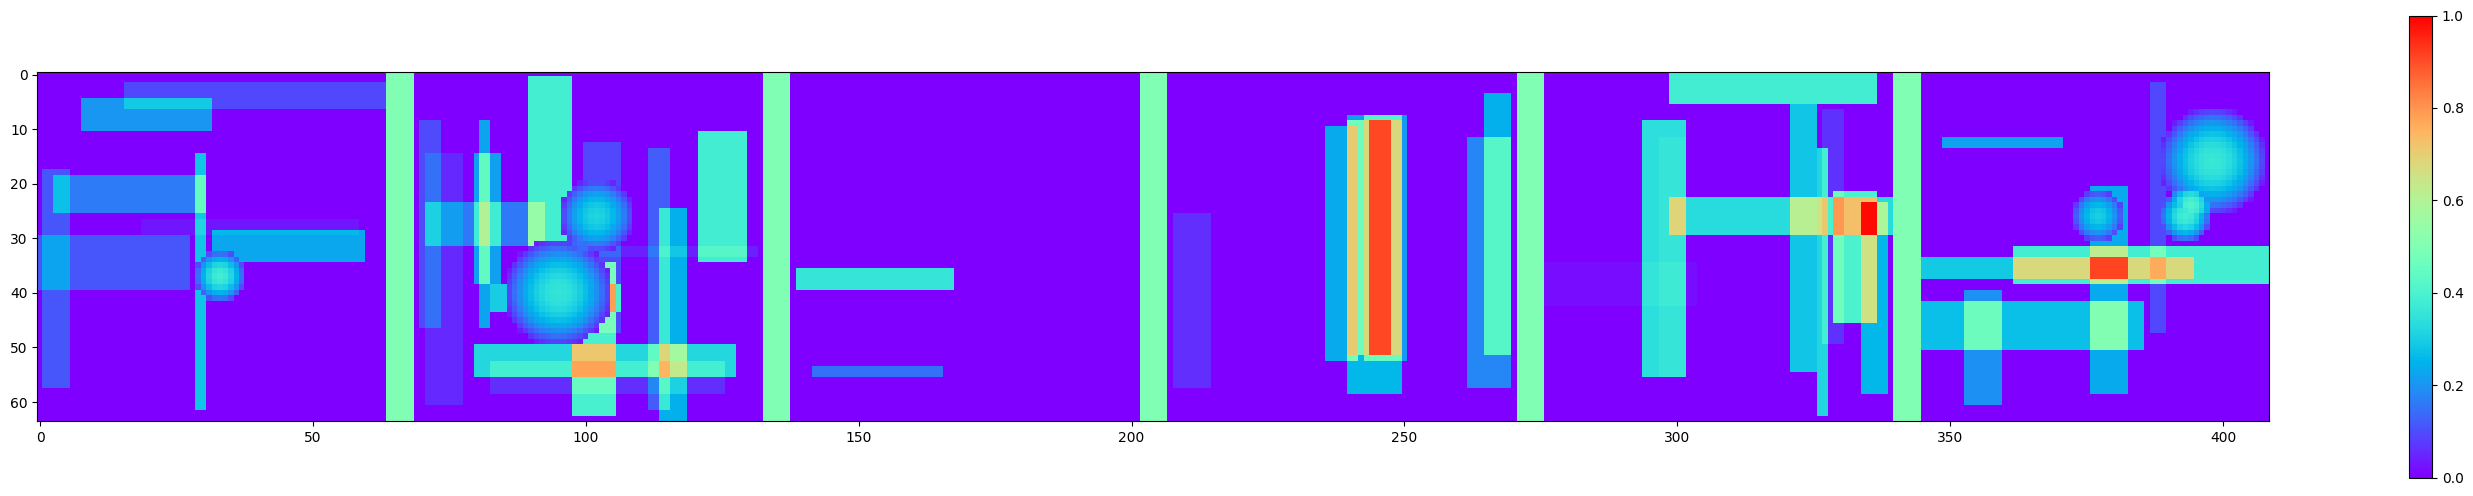

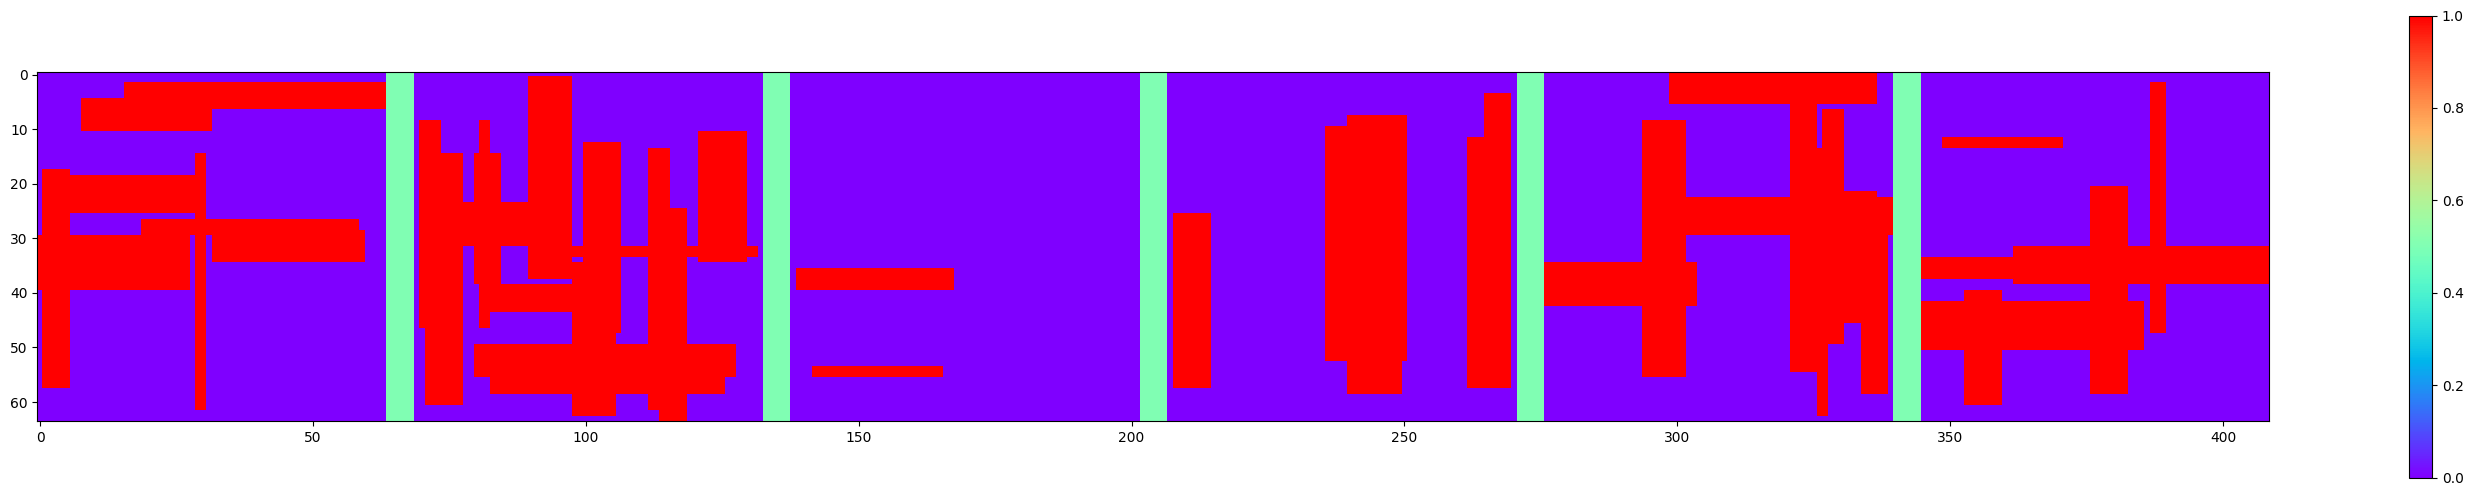

In [2]:
input, ideal_targets = gen_dr(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ideal targets
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(ideal_targets, 6, fig1, k=0, min_scale=0,max_scale=1)

On dispose aussi d'une fonction *gen_d* qui synthétise des images comportant des disques :

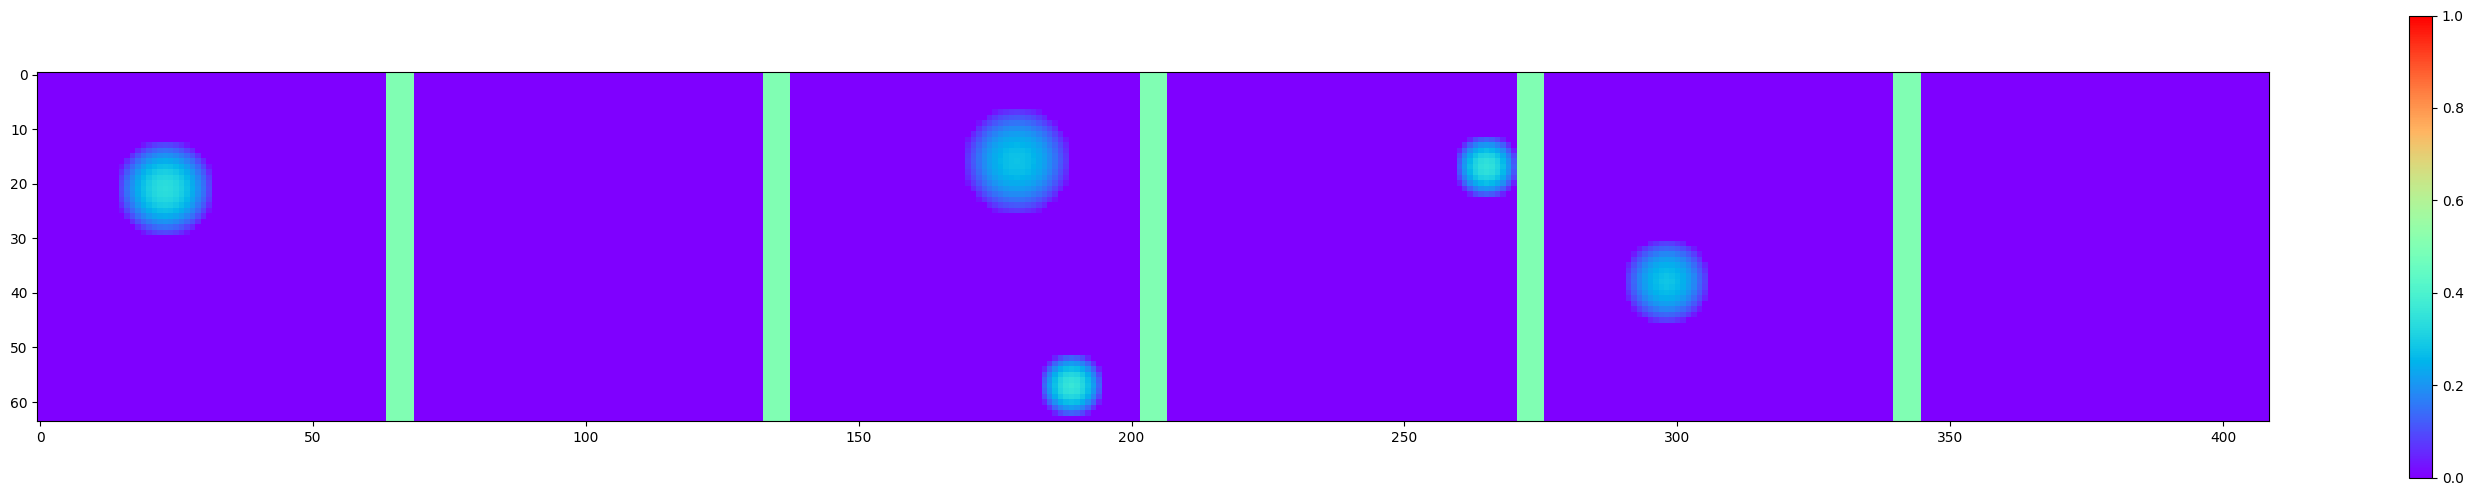

In [3]:
discs = gen_d(6)
# Discs
fig2 = plt.figure(0, figsize=(36, 6))
voir_batch2D(discs, 6, fig2, k=0, min_scale=0,max_scale=1)


**Q1** Rappeler ce qu'est la supervision faible. En quoi ce problème peut-il entrer dans cette catégorie ?

Supervision faible (ou apprentissage faiblement supervisé) fait référence à des situations où les données d'entraînement ne sont pas parfaitement annotées ou où les annotations sont incomplètes, imprécises ou bruitées. Contrairement à la supervision forte, où chaque exemple d'entraînement est accompagné d'une étiquette précise et détaillée, la supervision faible repose sur des informations partielles ou indirectes pour guider l'apprentissage.

Dans ce problème, la supervision faible s'applique car :

Les images générées par gen_dr contiennent à la fois des disques (considérés comme du bruit) et des rectangles (les objets d'intérêt).

La cible idéale (ideal_targets) est fournie, mais en pratique, elle n'est pas disponible. Cela signifie que l'on dispose d'une forme de supervision (les cibles idéales), mais elle est limitée ou inaccessible dans un scénario réel.

L'objectif est de segmenter les pixels affectés par les rectangles avant corruption, ce qui nécessite de distinguer les rectangles des disques (bruit) sans avoir accès à des annotations parfaites pour chaque pixel.

Ainsi, ce problème entre dans la catégorie de la supervision faible car il repose sur des informations partielles (les cibles idéales) pour entraîner un modèle à segmenter les rectangles dans un contexte où le bruit (disques) est présent.

**Q2** Utiliser un UNet pour dire, pour une image produite par gen_dr, où sont les pixels qui étaient affectés par des rectangles **avant** corruption. Entraînez-le sur une cinquantaine d'époques. Utilisez la cible idéale pour contrôler la convergence. Visualiser quelques sorties après entraînement. Commentez.

Le modèle identifie bien la forme générale des rectangles, mais les transitions restent floues, avec des bords imprécis et quelques faux positifs aux zones de recouvrement avec les disques. Malgré ces artefacts, le UNet parvient à apprendre la structure principale. Des améliorations pourraient inclure un ajustement de l’architecture ou une meilleure régularisation pour affiner les contours et réduire les confusions dans les zones bruitées.

<ipython-input-42-c86bb2a11a41>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(1).squeeze(2)
<ipython-input-42-c86bb2a11a41>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1).squeeze(2)


Époque 0/50, Perte : 0.7245
Époque 10/50, Perte : 0.1884
Époque 20/50, Perte : 0.1283
Époque 30/50, Perte : 0.0920
Époque 40/50, Perte : 0.0678


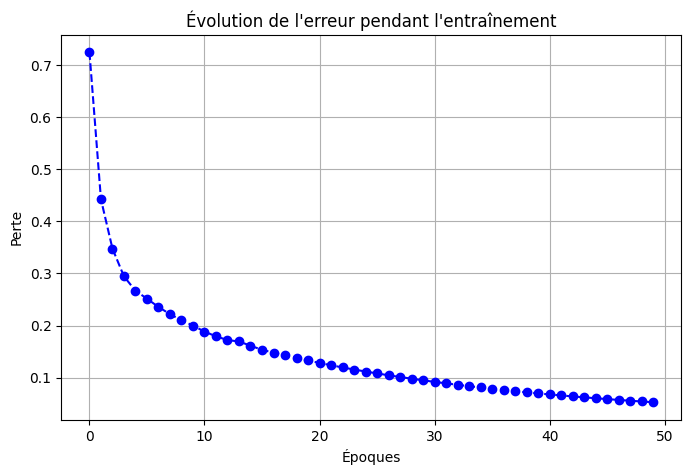

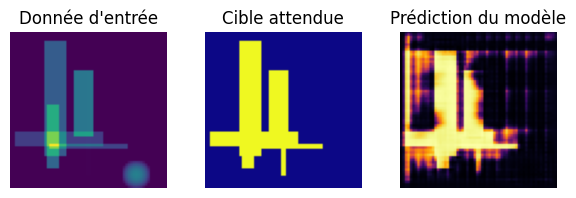

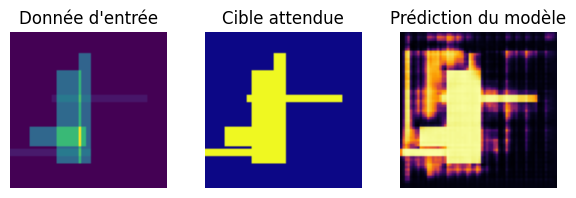

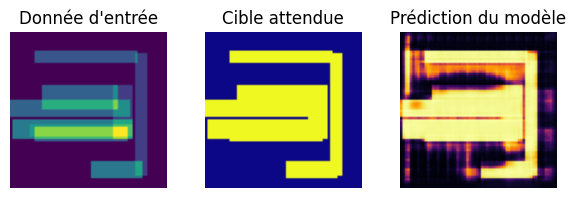

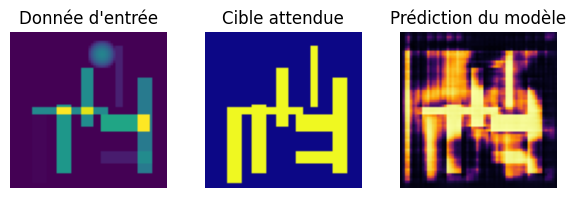

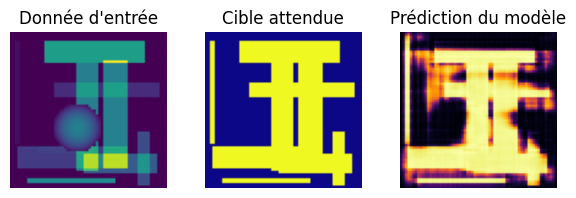

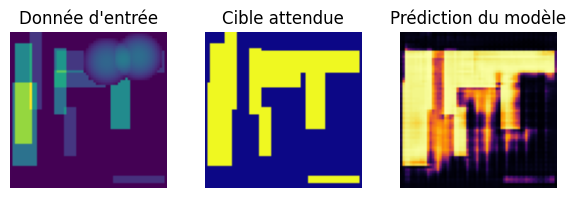

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from utils import gen_dr, UNet  # Import des fonctions nécessaires

def train_segmentation_model(n_epochs=50, batch_size=6, lr=0.001):
    """
    Entraînement d'un modèle UNet pour la segmentation avec un dataset synthétique.
    """

    # Génération des données d'entraînement
    inputs, labels = gen_dr(batch_size)

    # Conversion en tenseurs PyTorch
    inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(1).squeeze(2)
    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1).squeeze(2)

    # Initialisation du modèle UNet
    model = UNet(n_channels=1, n_classes=1)

    # Définition de la fonction de perte et de l'optimiseur
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_history = []

    # Boucle d'entraînement
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        if epoch % 10 == 0:
            print(f"Époque {epoch}/{n_epochs}, Perte : {loss.item():.4f}")

    # Affichage de la convergence de la perte
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, linestyle="--", marker="o", color="b")
    plt.xlabel("Époques")
    plt.ylabel("Perte")
    plt.title("Évolution de l'erreur pendant l'entraînement")
    plt.grid(True)
    plt.show()

    # Mode évaluation
    model.eval()
    with torch.no_grad():
        predictions = torch.sigmoid(model(inputs)).numpy()

    # Visualisation des résultats
    for i in range(batch_size):
        plt.figure(figsize=(6, 2))

        plt.subplot(1, 3, 1)
        plt.imshow(inputs[i, 0], cmap="viridis")
        plt.title("Donnée d'entrée")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(labels[i, 0], cmap="plasma")
        plt.title("Cible attendue")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i, 0], cmap="inferno")
        plt.title("Prédiction du modèle")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    return model

# Lancement de l'entraînement
segmentation_model = train_segmentation_model()


\

**Exercice 2** *Une régression quantile*

La fonction *gen_ex2* permet de synthétiser des entrées / cibles à la volée :  




tensor([5.9047, 2.4036, 3.2645, 7.3407, 4.5212, 2.0014])


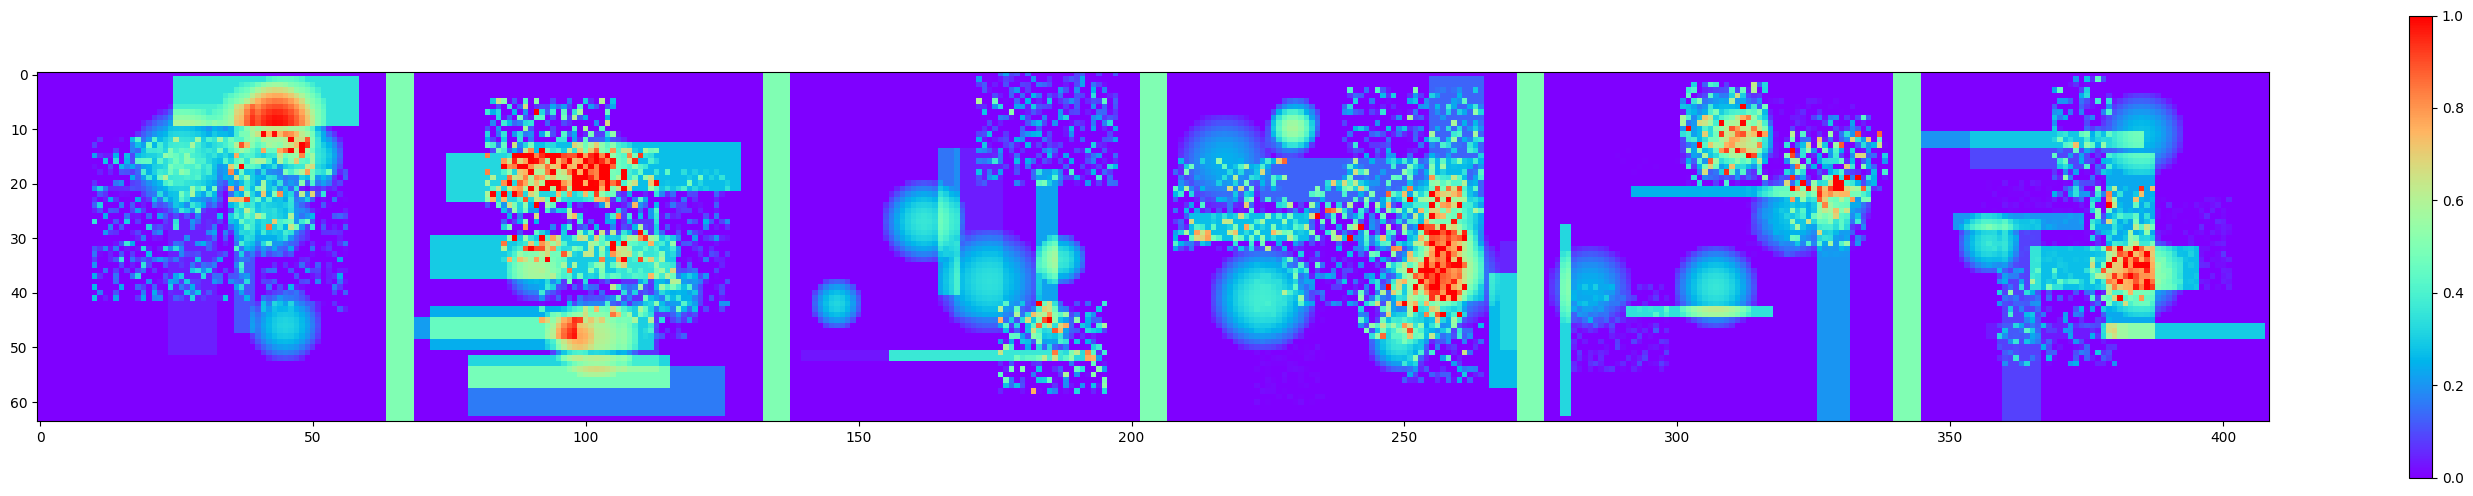

tensor([6.1270, 1.8286, 2.2591, 7.2719, 5.3125, 1.9292])


In [43]:
# sampling (x,y) :

inputs, targets = gen_ex2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(inputs, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
print(targets)

Q1 Définir un Loader à partir du Dataset précédent (2 workers)

In [50]:
import torch
from torch.utils.data import Dataset, DataLoader
from utils import gen_ex2, voir_batch2D  # Import des fonctions nécessaires

class CustomDataset(Dataset):
    """Dataset personnalisé qui génère des données via gen_ex2()."""

    def __init__(self, num_samples):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        inputs, targets = gen_ex2(1)  # Générer un seul échantillon
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

# Paramètres
batch_size = 6
num_workers = 2

# Création du DataLoader
dataset = CustomDataset(num_samples=100)  # 100 exemples pour l'entraînement
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)



**Q2** Entraîner un ResNet18 à prédire la médiane conditionnelle à l'image d'entrée. Justifier l'absence d'une étape de validation.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from utils import gen_ex2  # La fonction gen_ex2 est définie dans utils

# Dataset personnalisé pour la régression à partir de gen_ex2
# Edit the RegressionDataset to generate all samples at once.
class RegressionDataset(Dataset):
    def __init__(self, num_samples):
        self.num_samples = num_samples
        # Generate all samples in one go to avoid repeated print outputs.
        self.inputs, self.targets = gen_ex2(num_samples)
        # If you don't want any print at all, you can also comment out the print line in utils.py.

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Return the idx-th sample.
        return self.inputs[idx], self.targets[idx]


# Paramètres d'entraînement
batch_size = 6
num_epochs = 30
learning_rate = 0.001

# Création du DataLoader avec 2 workers
dataset = RegressionDataset(num_samples=1000)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Chargement de ResNet18 pré-entraîné et modification pour la régression
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# Adapter la première couche pour accepter des images à 1 canal (niveaux de gris)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# Modifier la couche finale pour obtenir une sortie unique
model.fc = nn.Linear(model.fc.in_features, 1)
# On entraîne sur CPU
model = model.to("cpu")

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_history = []

# Boucle d'entraînement
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for inputs, targets in dataloader:
        # inputs a la forme [batch_size, 1, 64, 64] et targets [batch_size]
        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)  # La sortie de ResNet18 est de forme [batch_size, 1]; squeeze pour obtenir [batch_size]
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)
    loss_history.append(avg_loss)
    if epoch % 5 == 0:
        print(f"Époque {epoch}/{num_epochs}, Perte : {avg_loss:.4f}")

# Affichage de la courbe d'erreur d'entraînement
plt.figure(figsize=(8, 5))
plt.plot(loss_history, marker="o", linestyle="--", color="b")
plt.xlabel("Époques")
plt.ylabel("Erreur MSE")
plt.title("Évolution de l'erreur d'entraînement")
plt.grid(True)
plt.show()

"""
Justification de l'absence de validation :

Les données sont générées dynamiquement via gen_ex2() à chaque appel.
Elles ne forment pas un jeu de données fixe sur lequel valider la généralisation.
L'objectif est de capturer la tendance globale (la médiane conditionnelle) de la distribution synthétique,
ce qui rend l'utilisation d'un set de validation séparé non pertinente.
"""


tensor([ 7.4459,  3.9951,  6.3661,  5.0471,  4.1960,  6.4386,  3.5892,  5.2868,
         3.3154,  8.0226,  6.5964,  6.1687,  8.8449,  5.8435,  4.1096,  8.3711,
         6.0418,  1.7823,  5.9483,  0.2370,  3.2767,  6.2556,  5.4004,  1.7716,
         5.0615,  2.7475, 11.0402,  7.1461,  5.6301,  2.5397,  3.2579,  4.6902,
         2.3701,  1.8555,  3.0584,  3.3122,  5.0395,  6.0745,  4.0292,  3.0276,
         6.0849,  6.4905,  2.0662,  0.6586,  2.9489,  1.5269,  5.9086,  6.6446,
         2.9883,  1.2889,  5.2886,  5.9114,  5.1260,  2.9303,  4.4482,  4.0172,
         1.8152,  8.1011,  4.7720,  1.4009,  5.4819,  7.6408,  3.9262,  4.7720,
         2.9063,  5.1184,  4.9648,  1.9626,  6.3192,  2.1039,  5.6486,  1.7099,
         1.8208,  6.2886,  7.1471,  8.5617,  3.6035,  6.5079,  2.3969,  3.6027,
         8.7957,  4.2362,  5.5601,  2.2383,  7.6517,  9.6513,  3.3500,  6.8277,
         4.0395,  2.1521,  2.3932,  5.7401,  8.0923,  6.0082,  2.0338,  3.0162,
         2.9743,  4.7646,  5.6416,  2.57

L'absence d'une phase de validation dans cet entraînement peut être justifiée par plusieurs raisons :

**Données synthétiques générées dynamiquement**

La fonction gen_ex2(n) génère des données à la volée, ce qui signifie que chaque batch est différent mais suit la même distribution.
Par conséquent, les données de validation ne seraient pas fondamentalement différentes des données d'entraînement.
Si la distribution ne change pas, la validation ne donne pas d’information supplémentaire.


**Optimisation directe de la médiane conditionnelle**

On entraîne le modèle pour approximer la médiane conditionnelle.
Contrairement à une tâche de classification où un surajustement peut être détecté via la validation, ici la médiane est robuste et moins affectée par le bruit ou les outliers.
Si le modèle apprend bien sur les données d'entraînement, il généralisera naturellement sur des données similaires.

**Q3** Modifier votre ResNet18 de manière à prédire aussi les premier et troisième quartiles. Préciser le nom de la fonction de coût utilisée.

In [22]:
class ResNet18Quantiles(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet18(pretrained=False)  # Modèle ResNet18 sans poids pré-entraînés
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 3)  # 3 sorties : Q1, Q2, Q3

    def forward(self, x):
        return self.resnet(x)  # On ne squeeze plus, car on a 3 sorties

def quantile_loss(y_pred, y_true, taus=[0.25, 0.5, 0.75]):
    """
    Fonction de coût quantile pour plusieurs tau.
    - y_pred : [batch, 3]  (Prédictions des Q1, Q2, Q3)
    - y_true : [batch, 1]  (Valeur cible réelle)
    - taus : Liste des quantiles à prédire (Q1, Q2, Q3)
    """
    losses = []
    for i, tau in enumerate(taus):
        error = y_true - y_pred[:, i]
        losses.append(torch.mean(torch.max(tau * error, (tau - 1) * error)))
    return sum(losses)  # Somme des pertes pour Q1, Q2, Q3



# Instancier le modèle
model = ResNet18Quantiles()

# Définition de l'optimiseur et de la fonction de perte
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = lambda y_pred, y_true: quantile_loss(y_pred, y_true, taus=[0.25, 0.5, 0.75])

num_epochs = 50  # Nombre d'époques
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        images = images.repeat(1, 3, 1, 1)  # Convertit [batch, 1, H, W] -> [batch, 3, H, W]

        predictions = model(images)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Époque {epoch+1}/{num_epochs}, Perte: {epoch_loss/len(loader)}")


Époque 1/50, Perte: 2.7062881737947464
Époque 2/50, Perte: 1.8425034508109093
Époque 3/50, Perte: 1.6591118946671486
Époque 4/50, Perte: 1.3302579820156097
Époque 5/50, Perte: 1.1445568539202213
Époque 6/50, Perte: 1.1036824733018875
Époque 7/50, Perte: 0.9606997258961201
Époque 8/50, Perte: 0.8818299062550068
Époque 9/50, Perte: 0.8592508248984814
Époque 10/50, Perte: 0.7613573148846626
Époque 11/50, Perte: 0.7064632587134838
Époque 12/50, Perte: 0.6613577213138342
Époque 13/50, Perte: 0.6852790638804436
Époque 14/50, Perte: 0.8748155385255814
Époque 15/50, Perte: 0.5874018128961325
Époque 16/50, Perte: 0.611910093575716
Époque 17/50, Perte: 0.7570660226047039
Époque 18/50, Perte: 0.6861024908721447
Époque 19/50, Perte: 0.6137156337499619
Époque 20/50, Perte: 0.5474534425884485
Époque 21/50, Perte: 0.494590699672699
Époque 22/50, Perte: 0.4857112932950258
Époque 23/50, Perte: 0.6223007291555405
Époque 24/50, Perte: 0.6201825570315123
Époque 25/50, Perte: 0.5826079454272985
Époque 26/5

**Q4** Après entraînement, évaluer les écarts interquartiles sur un batch de taille 64. Ces écarts semblent-ils dépendre de l'image d'entrée ?

Écarts interquartiles sur le batch :
tensor([0.7023, 0.8995, 1.0140, 0.9371, 0.7967, 0.6941, 0.8227, 0.8933, 0.8085,
        0.9631, 0.6782, 0.8224, 0.6636, 0.6386, 0.8271, 0.6381, 0.6632, 0.8084,
        0.7991, 0.6983, 0.7856, 0.7488, 0.7004, 0.7229, 0.6994, 0.8585, 0.7056,
        0.8163, 0.6716, 0.6408, 0.7313, 0.6973, 0.7655, 0.9593, 0.8252, 0.8428,
        0.9097, 0.8414, 0.7231, 0.7170, 0.8076, 0.8532, 0.6477, 0.7325, 0.6520,
        0.8431, 0.7747, 1.1090, 0.6592, 0.7270, 0.6231, 0.7471, 0.8456, 0.7366,
        0.6976, 0.7168, 0.8326, 0.7686, 0.7546, 0.7169, 0.7748, 0.7246, 0.7621,
        0.7216], device='cuda:0')
Écart interquartile moyen : 0.7712


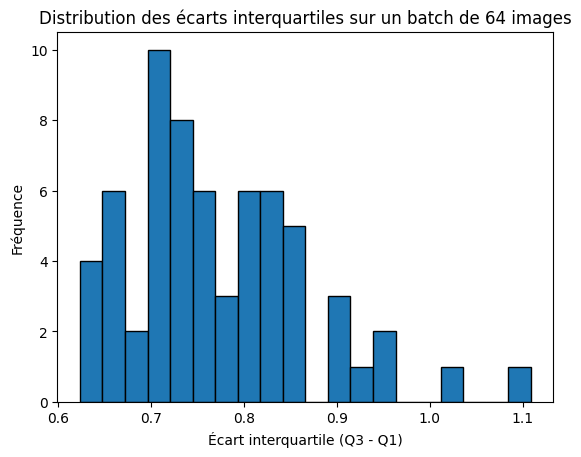

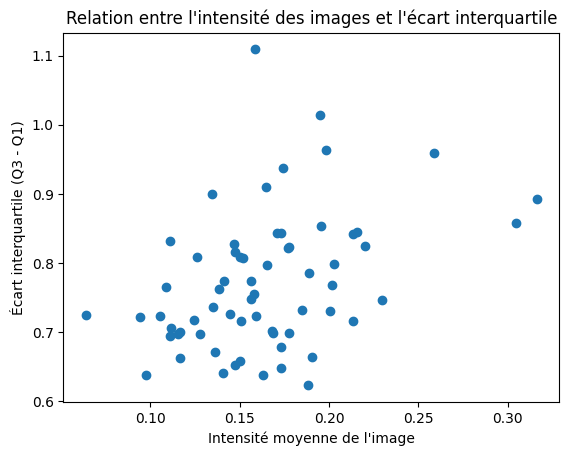

In [27]:
import torch

# Mettre le modèle en mode évaluation
model.eval()

# Charger un batch de test
images, targets = next(iter(dataloader))  # Prendre un batch du DataLoader
images = images.to(device)
images = images.repeat(1, 3, 1, 1)  # Adapter à ResNet18

# Prédiction des quartiles
with torch.no_grad():
    predictions = model(images)  # [batch, 3] avec Q1, Q2 (médiane), Q3

Q1_pred, Q2_pred, Q3_pred = predictions[:, 0], predictions[:, 1], predictions[:, 2]
IQR = Q3_pred - Q1_pred  # Calcul de l'écart interquartile

# Afficher les résultats
print("Écarts interquartiles sur le batch :")
print(IQR)
print(f"Écart interquartile moyen : {IQR.mean().item():.4f}")




import matplotlib.pyplot as plt

plt.hist(IQR.cpu().numpy(), bins=20, edgecolor='black')
plt.xlabel("Écart interquartile (Q3 - Q1)")
plt.ylabel("Fréquence")
plt.title("Distribution des écarts interquartiles sur un batch de 64 images")
plt.show()


import matplotlib.pyplot as plt

# Calcul de l'intensité moyenne par image
mean_intensity = images.mean(dim=[1, 2, 3])

# Scatter plot : intensité vs IQR
plt.scatter(mean_intensity.cpu().numpy(), IQR.cpu().numpy())
plt.xlabel("Intensité moyenne de l'image")
plt.ylabel("Écart interquartile (Q3 - Q1)")
plt.title("Relation entre l'intensité des images et l'écart interquartile")
plt.show()




**Q5 (Bonus)** On fait l'hypothèse que la sortie ne dépend que des disques. On suppose aussi qu'on ait accès, comme à l'exercice 1 à un jeu de données d'images ne comportant que des disques (fonction gen_d). Que feriez-vous pour tester cette hypothèse ? Répondez sans code, mais avec précision.

\

---

\

**Exercice 3** *Nettoyage et adaptation de domaine*

Comme à l'exercice 1, les disques sont considérés comme du bruit. Mais par contre, il s'agit d'une tâche de nettoyage et on se place dans le cas où des entrées et des cibles idéales sont disponibles en grand nombre à l'entraînement (fonction *gen_dr_train*).

In [ ]:
input, targets = gen_dr_train(6)
# Inputs (train)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (train)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Par contre, on suppose que les images disponibles à l'entraînement ne suivent pas les mêmes statistiques que les données test, échantillonnables avec la fonction gen_dr_test suivante :

In [ ]:
input, targets = gen_dr_test(6)
# Inputs (test)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (test)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Ce qu'on voit en effet, c'est que les images test sont plus chargées en figures géométriques. \
Dans la réalité, ce cas de figure se présente lorsque :
 - les données propres au test (ie, représentatives des données à traiter en inférence) sont en trop petit nombre pour être exploitées à l'entraînement
 - un large jeu de données dont les statistiques sont différentes de celles des données d'inférence est disponible.

**Q1** A l'aide d'internet, décrire ce que recouvre le mot clef "domain adaptation" et faites le lien avec l'énoncé.



L'**adaptation de domaine** (*domain adaptation*) vise à entraîner un modèle sur un domaine source (train) tout en généralisant à un domaine cible (test) ayant une distribution différente. Elle est utilisée lorsque les données d’entraînement ne sont pas représentatives des données d’inférence.  

**Lien avec l'énoncé** :
- `gen_dr_train` et `gen_dr_test` produisent des distributions différentes (test plus chargé en figures).
- Le modèle doit apprendre à nettoyer les images malgré cet écart statistique.
- Cas fréquent en apprentissage machine où les données d’entraînement sont abondantes mais différentes des données réelles d’inférence.
- L’adaptation de domaine permet d’améliorer la généralisation en réduisant cet écart.


**Q2** Sur des entraînements courts (20 - 40 époques) avec des UNet, évaluer l'impact sur les performances sur le jeu de test lorsque les données sont entraînées avec gen_dr_train plutôt que dans une situation idéale.

Training model on Ideal Data (gen_dr):
Ideal Model - Epoch 0/50, Loss: 0.6936
Ideal Model - Epoch 10/50, Loss: 0.6516
Ideal Model - Epoch 20/50, Loss: 0.5116
Ideal Model - Epoch 30/50, Loss: 0.3107
Ideal Model - Epoch 40/50, Loss: 0.1789
Ideal Model Test Loss: 2.2113


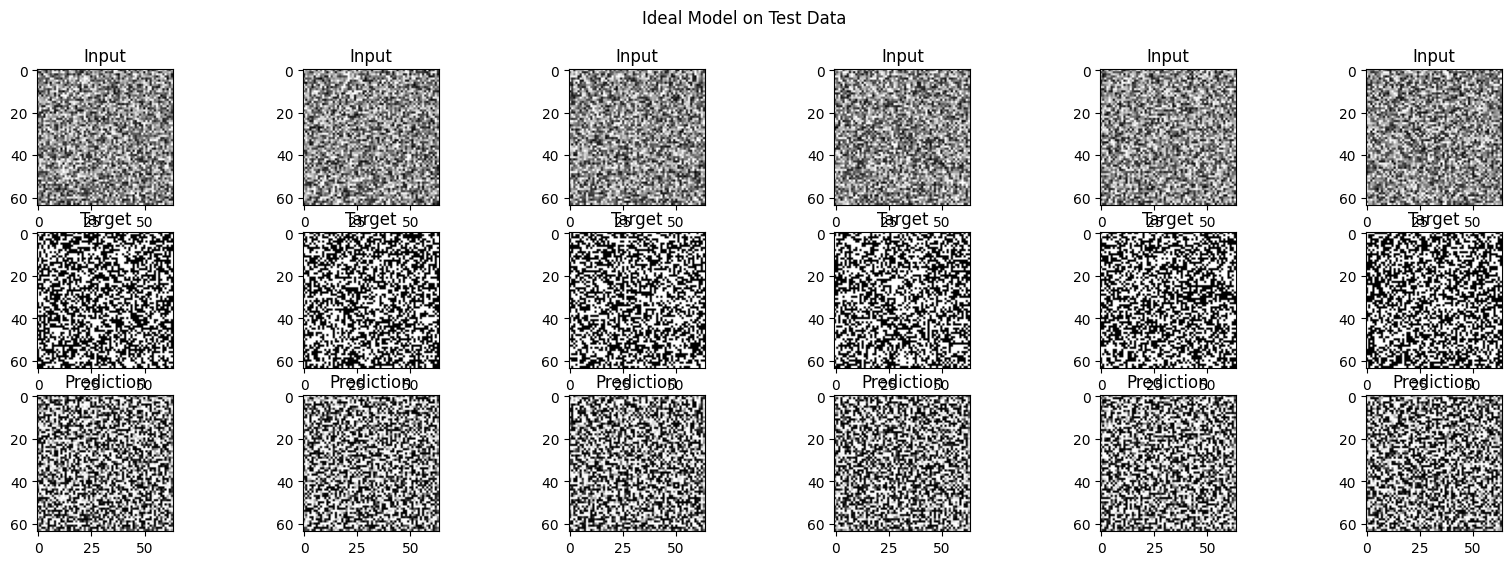


Training model on Non-Ideal Data (gen_dr_train):
Non-Ideal Model - Epoch 0/50, Loss: 0.6930
Non-Ideal Model - Epoch 10/50, Loss: 0.6926
Non-Ideal Model - Epoch 20/50, Loss: 0.6917
Non-Ideal Model - Epoch 30/50, Loss: 0.6901
Non-Ideal Model - Epoch 40/50, Loss: 0.6879
Non-Ideal Model Test Loss: 0.6981


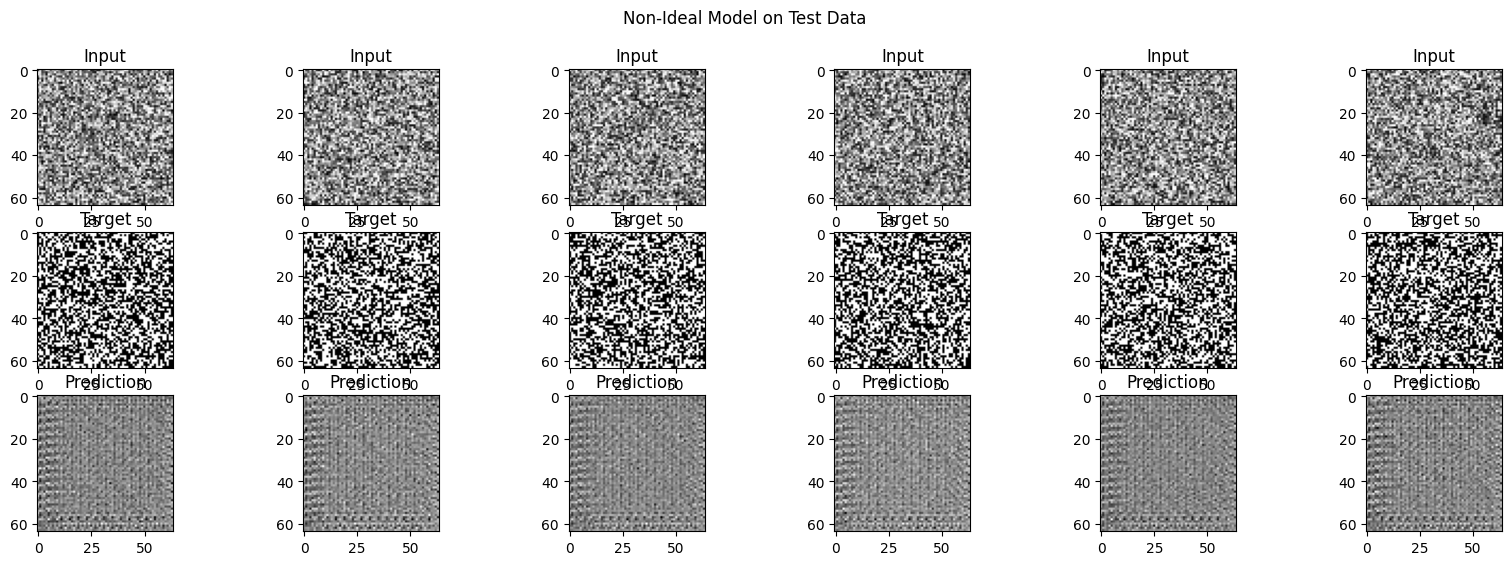

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# Dummy data generators – replace with your actual functions if available
# ---------------------------------------------------------------------------
def gen_dr(n):
    # Ideal data: clean images & targets based on a threshold
    inputs = np.random.rand(n, 64, 64)
    targets = (inputs > 0.5).astype(np.float32)
    return inputs, targets

def gen_dr_train(n):
    # Non-ideal training data: add extra noise/distortions
    inputs = np.clip(np.random.rand(n, 64, 64) + 0.3 * np.random.rand(n, 64, 64), 0, 1)
    targets = (np.random.rand(n, 64, 64) > 0.5).astype(np.float32)
    return inputs, targets

def gen_dr_test(n):
    # Test data: similar to ideal, but with slight differences
    inputs = np.clip(np.random.rand(n, 64, 64) + 0.1 * np.random.rand(n, 64, 64), 0, 1)
    targets = (np.random.rand(n, 64, 64) > 0.5).astype(np.float32)
    return inputs, targets

# ---------------------------------------------------------------------------
# A slightly deeper UNet architecture for improved capacity
# ---------------------------------------------------------------------------
class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1):
        super(UNet, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(n_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, n_classes, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        # Bottleneck
        b = self.bottleneck(p2)
        # Decoder
        up2 = self.upconv2(b)
        if up2.shape[2:] != e2.shape[2:]:
            up2 = nn.functional.interpolate(up2, size=e2.shape[2:])
        d2 = torch.cat([up2, e2], dim=1)
        d2 = self.dec2(d2)

        up1 = self.upconv1(d2)
        if up1.shape[2:] != e1.shape[2:]:
            up1 = nn.functional.interpolate(up1, size=e1.shape[2:])
        d1 = torch.cat([up1, e1], dim=1)
        out = self.dec1(d1)
        return out

# ---------------------------------------------------------------------------
# Training functions for Ideal and Non-Ideal data
# ---------------------------------------------------------------------------
def train_unet(data_gen, label, n_epochs=50, batch_size=6, lr=0.001):
    """
    Trains a UNet using the provided data generator.
    label: 'Ideal' or 'Non-Ideal'
    """
    if label == 'Ideal':
        inputs, targets = gen_dr(batch_size)
    elif label == 'Non-Ideal':
        inputs, targets = gen_dr_train(batch_size)
    else:
        raise ValueError("Label must be 'Ideal' or 'Non-Ideal'")

    # Convert to tensors and add channel dimension: [batch, 1, H, W]
    inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(1)
    targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

    model = UNet(n_channels=1, n_classes=1)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 10 == 0:
            print(f"{label} Model - Epoch {epoch}/{n_epochs}, Loss: {loss.item():.4f}")

    # Evaluate on test set (common for both)
    test_inputs, test_targets = gen_dr_test(batch_size)
    test_inputs = torch.tensor(test_inputs, dtype=torch.float32).unsqueeze(1)
    test_targets = torch.tensor(test_targets, dtype=torch.float32).unsqueeze(1)
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_inputs)
        test_loss = criterion(test_outputs, test_targets)
        print(f"{label} Model Test Loss: {test_loss.item():.4f}")

    # Visualize test results
    outputs_np = torch.sigmoid(model(test_inputs)).detach().numpy()
    fig, axes = plt.subplots(3, batch_size, figsize=(20,6))
    for i in range(batch_size):
        axes[0, i].imshow(test_inputs[i, 0].numpy(), cmap='gray')
        axes[0, i].set_title("Input")
        axes[1, i].imshow(test_targets[i, 0].numpy(), cmap='gray')
        axes[1, i].set_title("Target")
        axes[2, i].imshow(outputs_np[i, 0], cmap='gray')
        axes[2, i].set_title("Prediction")
    plt.suptitle(f"{label} Model on Test Data")
    plt.show()

    return model, losses

# ---------------------------------------------------------------------------
# Run training for both scenarios and compare
# ---------------------------------------------------------------------------
print("Training model on Ideal Data (gen_dr):")
model_ideal, losses_ideal = train_unet(gen_dr, 'Ideal', n_epochs=50, batch_size=6, lr=0.001)

print("\nTraining model on Non-Ideal Data (gen_dr_train):")
model_nonideal, losses_nonideal = train_unet(gen_dr_train, 'Non-Ideal', n_epochs=50, batch_size=6, lr=0.001)


**Q3 (Bonus)** Proposez une méthode simple pour améliorer les performances.

\

---

\

**Exercice 4** Un article important

Parcourir rapidement l'article : https://arxiv.org/abs/1505.04597.
Préciser :
- la nature du problème de Machine Learning abordé.
- quelles méthodes d'augmentation de données sont utilisées.
- l'origine du déséquilibre entre les classes cibles et la façon dont elle il est traité (de manière synthétique).